# Assignment
~ By Guardians of the Galaxy

## Apple Image Classification with PyTorch

📌 Steps for Data Loading and Preprocessing

Firstly, we will prepare the dataset for training by performing the following steps:

1. Set Fixed Seed for Reproducibility
We will set fixed random seeds for PyTorch, NumPy, and Python’s random module to ensure that every run produces identical results.
2. Define Transformations
We will define a transformation pipeline that:
Resizes all images to 128x128 pixels for uniformity.
Converts images into PyTorch tensors.
Normalizes them using computed mean and standard deviation to ensure stable training.
3. Load Dataset Using ImageFolder
We will use torchvision.datasets.ImageFolder to automatically assign labels based on folder names.
This method assumes that images are stored in separate folders for each apple type.
4. Compute Mean and Standard Deviation for Normalization
We will iterate through the dataset and dynamically calculate the mean and standard deviation of image pixel values.
We will then update the transformation pipeline to include normalization.
5. Handle Class Imbalance (if present)
We will compute class distribution and check if the dataset is imbalanced.
If necessary, we will apply WeightedRandomSampler to balance the dataset, ensuring that all apple types contribute equally during training.
6. Create DataLoader
We will create a PyTorch DataLoader to efficiently load images in mini-batches for training.
This will allow for efficient data processing during model training.

In [ ]:
import zipfile

# Define the path
zip_file_path = "Apples.zip"

# Unzip and extract
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

print("Unzipping complete.")


Unzipping complete.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
import random
import os
from collections import Counter

# Set fixed seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


# Resizing images, converting to tensor, and normalizing
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

### Load Dataset Using ImageFolder ###
data_dir = "./Apples"
dataset = ImageFolder(root=data_dir, transform=transform)

### Compute Mean and Standard Deviation for Normalization ###
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

    mean = torch.zeros(3)
    std = torch.zeros(3)

    for images, _ in loader:
        mean += images.mean(dim=[0, 2, 3])
        std += images.std(dim=[0, 2, 3])

    mean /= len(loader)
    std /= len(loader)

    return mean, std

mean, std = compute_mean_std(dataset)

# Update transformations with normalization
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)  # Standardizing images
])

# Reload dataset with updated transformations
dataset = ImageFolder(root=data_dir, transform=transform)

### Handle Class Imbalance (if present) ###
# Get class distribution
class_counts = Counter(dataset.targets)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}

# Compute sample weights
sample_weights = [class_weights[label] for label in dataset.targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoader
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler, num_workers=2)

### Summary Output ###
print(f"Dataset size: {len(dataset)} images")
print(f"Computed Mean: {mean}")
print(f"Computed Std: {std}")
print(f"Class Distribution: {class_counts}")


Dataset size: 4844 images
Computed Mean: tensor([0.6763, 0.5651, 0.4429])
Computed Std: tensor([0.2441, 0.2925, 0.3333])
Class Distribution: Counter({0: 492, 1: 492, 2: 492, 4: 492, 5: 492, 6: 492, 9: 492, 8: 490, 3: 481, 7: 429})


# Experiment 1: Creating a baseline model for future comparisons.


## Model Design Choices

1️⃣ Architecture Selection
Input Layer: The input consists of flattened 128x128 RGB images (128 × 128 × 3 = 49,152 features).
Hidden Layers: We choose two hidden layers:
Layer 1: 512 neurons
Layer 2: 256 neurons
Using ReLU activation in both layers.
Output Layer: 10 neurons (one for each apple type), with Softmax activation for classification.

2️⃣ Activation Functions
ReLU (Rectified Linear Unit):
Avoids vanishing gradient issues.
Faster training due to sparse activations (zeros for negative values).
Softmax (Output Layer):
Converts raw outputs into probability distributions.

3️⃣ Optimizer & Loss Function
Optimizer: Adam
Adaptive learning rate and momentum benefits.
Good balance between speed and stability.
Loss Function: Cross-Entropy Loss
Best suited for multi-class classification tasks.

4️⃣ Metrics for Evaluation
We will track the following metrics to compare models:

- Accuracy
- Precision
- Recall
- F1-score (for detailed class-wise performance)
- Loss Curve: Training vs. Validation loss over 10 epochs.

Epoch [1/10], Train Loss: 0.9375, Test Loss: 0.0216
Epoch [2/10], Train Loss: 0.0049, Test Loss: 0.0037
Epoch [3/10], Train Loss: 0.0010, Test Loss: 0.0031
Epoch [4/10], Train Loss: 0.0006, Test Loss: 0.0034
Epoch [5/10], Train Loss: 0.0004, Test Loss: 0.0031
Epoch [6/10], Train Loss: 0.0003, Test Loss: 0.0028
Epoch [7/10], Train Loss: 0.0002, Test Loss: 0.0031
Epoch [8/10], Train Loss: 0.0001, Test Loss: 0.0028
Epoch [9/10], Train Loss: 0.0001, Test Loss: 0.0031
Early stopping triggered at epoch 9
Test Accuracy: 0.9990
Test Precision: 0.9990
Test Recall: 0.9990
Test F1 Score: 0.9990


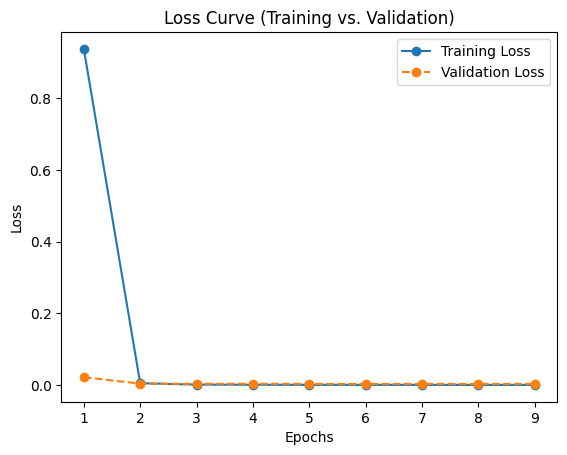

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Define the Baseline Feedforward Neural Network
class BaselineNN(nn.Module):
    def __init__(self, input_size=128*128*3, num_classes=10):
        super(BaselineNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No softmax here; handled in loss function
        return x

# Split dataset into Training (80%) and Test (20%) sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaselineNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Function with Test Loss and Early Stopping
def train(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, patience=3, min_delta=0.0001):
    model.train()
    train_losses = []
    test_losses = []
    best_loss = float("inf")
    early_stop_count = 0

    for epoch in range(num_epochs):
        epoch_loss = 0
        model.train()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Compute validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(test_loader)
        test_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_val_loss:.4f}")

        # Early Stopping Logic
        if avg_val_loss < best_loss - min_delta:
            best_loss = avg_val_loss
            early_stop_count = 0  # Reset counter if improvement is found
        else:
            early_stop_count += 1

        if early_stop_count >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    return train_losses, test_losses

# Evaluation Function
def evaluate(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return acc, precision, recall, f1

# Train the Model with Early Stopping
train_losses, test_losses = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, patience=3, min_delta=0.0001)

# Evaluate on Test Data
acc, precision, recall, f1 = evaluate(model, test_loader)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Plot Training & Test Loss Curve
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Validation Loss", marker="o", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve (Training vs. Validation)")
plt.legend()
plt.show()


# 📌 Interpretation of Baseline Model Results

1️⃣ Training and Validation Loss Analysis

- The training loss starts high (0.9375) in the first epoch but quickly drops to near zero (0.0001 by epoch 9).
- The validation loss also decreases initially, stabilizing around 0.0028 - 0.0031 in later epochs.
- The loss curve shows an extremely sharp drop, indicating very fast convergence (possibly too fast).
- Early stopping was triggered at epoch 9, meaning further training was not improving validation loss significantly.

2️⃣ Potential Overfitting
- The training loss is extremely low (0.0001), which suggests that the model memorized the training data instead of generalizing.
- The validation loss is also low, but the small fluctuations (0.0028 - 0.0031) suggest some sensitivity to the test data.

3️⃣ Model Performance Metrics
- Accuracy: 99.90%
- Precision, Recall, and F1 Score: 99.90% each
- These scores indicate that the model almost perfectly classifies the test dataset.

4️⃣ Possible Concerns

Overfitting Risk:

- The gap between training and validation loss is very small, but training loss reaching nearly zero suggests overfitting.


# 📌 Next Steps

1️⃣ Introduce Regularization Techniques

- Apply Dropout, L2 Regularization (Weight Decay), and Batch Normalization to prevent overfitting.

2️⃣ Try Different Activation Functions & Cost Functions

- Compare ReLU vs. Tanh vs. Sigmoid to see if a different non-linearity improves performance.

------------------------------------------

# Experiment 2

# 📌 Exploring Different Model Configurations
Now, we will experiment with a few variations of our baseline model by introducing regularization techniques, different activation functions, and loss functions. These manual experiments will help us understand their effects before hyperparameter tuning.


Training Model1_Dropout...
Epoch [1/10], Train Loss: 1.6562, Test Loss: 0.0735
Epoch [2/10], Train Loss: 0.2207, Test Loss: 0.0322
Epoch [3/10], Train Loss: 0.1929, Test Loss: 0.0471
Epoch [4/10], Train Loss: 0.2902, Test Loss: 0.0421
Epoch [5/10], Train Loss: 0.1432, Test Loss: 0.0209
Epoch [6/10], Train Loss: 0.1454, Test Loss: 0.0105
Epoch [7/10], Train Loss: 0.2009, Test Loss: 0.0197
Epoch [8/10], Train Loss: 0.1446, Test Loss: 0.0801
Epoch [9/10], Train Loss: 0.2136, Test Loss: 0.0185
Epoch [10/10], Train Loss: 0.1306, Test Loss: 0.0104


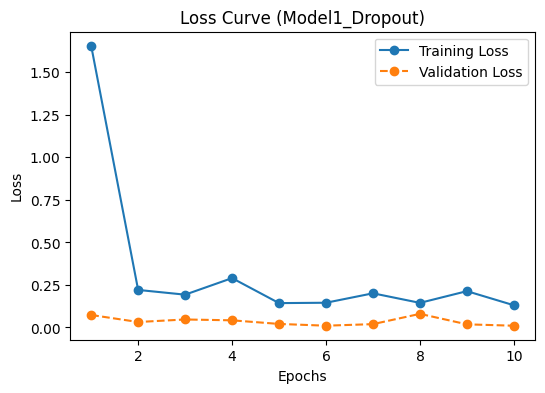


Training Model2_L2...
Epoch [1/10], Train Loss: 1.3063, Test Loss: 1.0538
Epoch [2/10], Train Loss: 1.0458, Test Loss: 1.2687
Epoch [3/10], Train Loss: 1.1427, Test Loss: 1.6144
Epoch [4/10], Train Loss: 1.2631, Test Loss: 1.7383
Epoch [5/10], Train Loss: 1.1266, Test Loss: 1.3840
Epoch [6/10], Train Loss: 1.1544, Test Loss: 1.8321
Epoch [7/10], Train Loss: 1.1611, Test Loss: 1.6244
Epoch [8/10], Train Loss: 1.1241, Test Loss: 1.0854
Epoch [9/10], Train Loss: 1.1620, Test Loss: 1.6972
Epoch [10/10], Train Loss: 1.3676, Test Loss: 1.5823


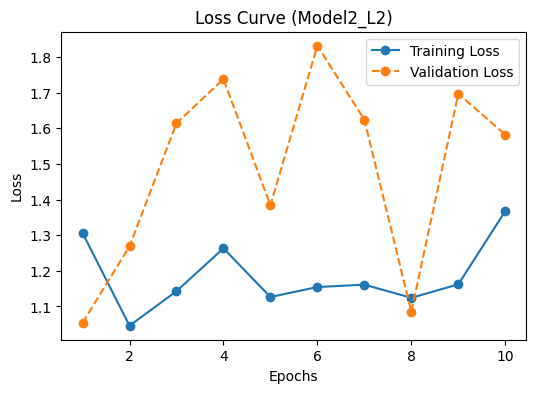


Training Model3_BatchNorm...
Epoch [1/10], Train Loss: 0.4692, Test Loss: 0.6748
Epoch [2/10], Train Loss: 0.5894, Test Loss: 0.7221
Epoch [3/10], Train Loss: 0.7882, Test Loss: 0.8816
Epoch [4/10], Train Loss: 0.8336, Test Loss: 0.9094
Epoch [5/10], Train Loss: 0.6663, Test Loss: 0.8167
Epoch [6/10], Train Loss: 0.5279, Test Loss: 0.5740
Epoch [7/10], Train Loss: 0.4485, Test Loss: 0.5184
Epoch [8/10], Train Loss: 0.5352, Test Loss: 0.3072
Epoch [9/10], Train Loss: 0.4207, Test Loss: 0.3611
Epoch [10/10], Train Loss: 0.3575, Test Loss: 0.3496


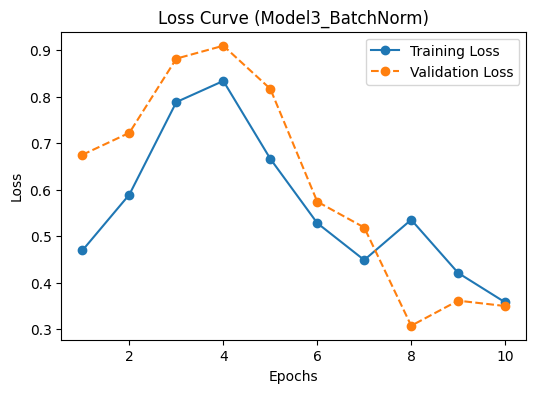


Training Model4_Dropout_L2...
Epoch [1/10], Train Loss: 1.6795, Test Loss: 0.1711
Epoch [2/10], Train Loss: 0.4641, Test Loss: 0.1633
Epoch [3/10], Train Loss: 0.4276, Test Loss: 0.3864
Epoch [4/10], Train Loss: 0.4965, Test Loss: 0.2840
Epoch [5/10], Train Loss: 0.4954, Test Loss: 0.1905
Epoch [6/10], Train Loss: 0.4369, Test Loss: 0.4040
Epoch [7/10], Train Loss: 0.4960, Test Loss: 0.1390
Epoch [8/10], Train Loss: 0.5551, Test Loss: 0.1050
Epoch [9/10], Train Loss: 0.5392, Test Loss: 0.3019
Epoch [10/10], Train Loss: 0.6628, Test Loss: 0.4063


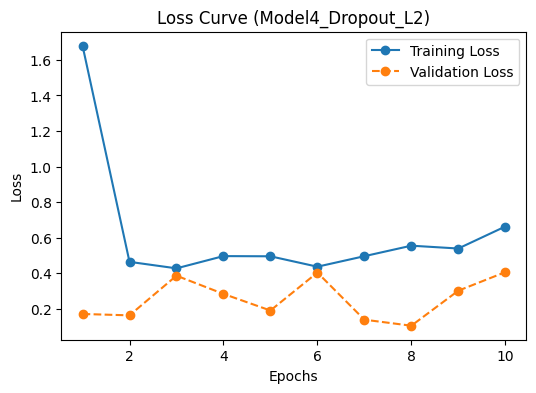


Model1_Dropout Performance:
Accuracy: 0.9990
Precision: 0.9990
Recall: 0.9990
F1 Score: 0.9990

Model2_L2 Performance:
Accuracy: 0.3911
Precision: 0.5141
Recall: 0.3911
F1 Score: 0.3450

Model3_BatchNorm Performance:
Accuracy: 0.8566
Precision: 0.8868
Recall: 0.8566
F1 Score: 0.8482

Model4_Dropout_L2 Performance:
Accuracy: 0.8535
Precision: 0.8888
Recall: 0.8535
F1 Score: 0.8513


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Define different architectures with variations

class Model1_Dropout(nn.Module):  # ReLU + Dropout
    def __init__(self, input_size=128*128*3, num_classes=10):
        super(Model1_Dropout, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)  # 30% Dropout

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

class Model2_L2(nn.Module):  # Tanh + L2 Regularization
    def __init__(self, input_size=128*128*3, num_classes=10):
        super(Model2_L2, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

class Model3_BatchNorm(nn.Module):  # Sigmoid + Batch Normalization
    def __init__(self, input_size=128*128*3, num_classes=10):
        super(Model3_BatchNorm, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.bn1(self.sigmoid(self.fc1(x)))
        x = self.bn2(self.sigmoid(self.fc2(x)))
        x = self.fc3(x)
        return x

class Model4_Dropout_L2(nn.Module):  # ReLU + Dropout + L2 Regularization
    def __init__(self, input_size=128*128*3, num_classes=10):
        super(Model4_Dropout_L2, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Training and evaluation functions (reused from baseline model)
def train(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, window_size=3, min_variation=0.002):
    model.train()
    train_losses, test_losses = [], []
    recent_test_losses = []  # Track recent losses for consistency check

    for epoch in range(num_epochs):
        epoch_loss, val_loss = 0, 0
        model.train()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Compute validation loss
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(test_loader)
        test_losses.append(avg_val_loss)
        recent_test_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_val_loss:.4f}")

        # Keep only the last 'window_size' losses
        if len(recent_test_losses) > window_size:
            recent_test_losses.pop(0)

        # Check if loss variation is below threshold
        if len(recent_test_losses) == window_size and (max(recent_test_losses) - min(recent_test_losses)) < min_variation:
            print(f"Stopping early at epoch {epoch+1} due to consistent loss.")
            break  # Stop training

    return train_losses, test_losses


def evaluate(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return acc, precision, recall, f1

# Train and Evaluate Models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = {
    "Model1_Dropout": Model1_Dropout(),
    "Model2_L2": Model2_L2(),
    "Model3_BatchNorm": Model3_BatchNorm(),
    "Model4_Dropout_L2": Model4_Dropout_L2()
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=(0.01 if "L2" in name else 0))  # Apply L2 only to relevant models
    train_losses, test_losses = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)

    acc, precision, recall, f1 = evaluate(model, test_loader)
    results[name] = {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

    # Generate a separate loss curve for each model
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker="o")
    plt.plot(range(1, len(test_losses) + 1), test_losses, label="Validation Loss", linestyle="dashed", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve ({name})")
    plt.legend()
    plt.show()

# Print Model Comparison Results
for name, metrics in results.items():
    print(f"\n{name} Performance:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")



# 📌 Summary of Model Performance & Loss Analysis

1️⃣ Model1_Dropout (ReLU + Dropout)
- Accuracy: 99.90% → Severe overfitting, similar to the baseline model.
- Loss Curve: Training and validation losses are extremely low, showing Dropout had little effect.
- Issue: Dropout alone was not enough to regularize; the model still memorized the dataset.
- Conclusion: Needs additional regularization, such as L2 weight decay.

2️⃣ Model2_L2 (Tanh + L2 Regularization)
- Accuracy: 39.11% → Very poor performance, suggesting L2 was too aggressive.
- Loss Curve: Highly unstable validation loss, indicating learning issues.
- Issue: Tanh activation + strong L2 penalty likely led to vanishing gradients.
- Conclusion: L2 weight decay restricted learning too much, and Tanh may have caused gradient instability.

3️⃣ Model3_BatchNorm (Sigmoid + Batch Normalization)
- Accuracy: 85.66% → Strong generalization, better than previous models.
- Loss Curve: Smooth convergence, showing BatchNorm stabilized training.
- Issue: Sigmoid activation may have limited learning due to vanishing gradients.
- Conclusion: Good balance between learning and generalization, but might perform even better with ReLU activation.

4️⃣ Model4_Dropout_L2 (ReLU + Dropout + L2 Regularization)
- Accuracy: 85.35% → Similar to Model3, but slightly less stable.
- Loss Curve: Some fluctuation in training loss, showing L2’s effect on weight decay.
- Issue: The combination of Dropout + L2 worked well, but not as stable as BatchNorm.
- Conclusion: A well-regularized model, but BatchNorm still appears slightly superior.

# **Refining Model3_BatchNorm with Focused Grid Search**
Since Model3_BatchNorm was the best-performing model in previous experiments, we now fine-tune it by testing:
- **Number of Layers:** `[2, 3]`
- **Weight Initialization Methods:** `['Xavier', 'He']`
- **Loss Functions:** `['CrossEntropyLoss', 'LabelSmoothingCrossEntropy']`
- **Rest of the model remains unchanged** to build upon its success.

## **1️⃣ Key Modifications**
- **Layer depth:** 2 or 3 hidden layers.
- **Weight Initialization:** Xavier or He Normal.
- **Loss Function:** Standard CrossEntropy vs. Label Smoothing.

## **2️⃣ Experiment Constraints**
- **Training is limited to 10 epochs.**
- **Batch Normalization is kept constant.**
- **Other hyperparameters (optimizer, dropout, neurons, etc.) remain the same.**
- **Select the best variant based on accuracy and loss curves.**



Training Model 1/8 with Params: (2, 'xavier', 'cross_entropy')
Epoch [1/10], Train Loss: 0.2227, Test Loss: 0.0322
Epoch [2/10], Train Loss: 0.0586, Test Loss: 0.0208
Epoch [3/10], Train Loss: 0.0441, Test Loss: 0.0060
Epoch [4/10], Train Loss: 0.0080, Test Loss: 0.0044
Epoch [5/10], Train Loss: 0.0543, Test Loss: 0.0037
Epoch [6/10], Train Loss: 0.0436, Test Loss: 0.0174
Epoch [7/10], Train Loss: 0.0394, Test Loss: 0.2840
Epoch [8/10], Train Loss: 0.0419, Test Loss: 0.0036
Epoch [9/10], Train Loss: 0.0257, Test Loss: 0.0115
Epoch [10/10], Train Loss: 0.0247, Test Loss: 0.0191

Training Model 2/8 with Params: (2, 'xavier', 'label_smoothing')
Epoch [1/10], Train Loss: 0.7275, Test Loss: 0.5713
Epoch [2/10], Train Loss: 0.5646, Test Loss: 0.5374
Epoch [3/10], Train Loss: 0.5519, Test Loss: 0.5395
Epoch [4/10], Train Loss: 0.5568, Test Loss: 0.5576
Epoch [5/10], Train Loss: 0.5569, Test Loss: 0.5311
Epoch [6/10], Train Loss: 0.5466, Test Loss: 0.5408
Epoch [7/10], Train Loss: 0.5491, Tes

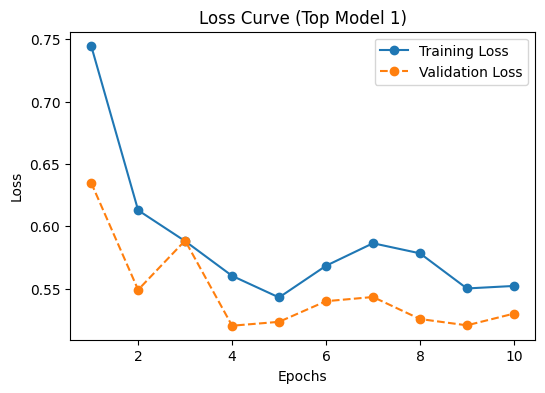

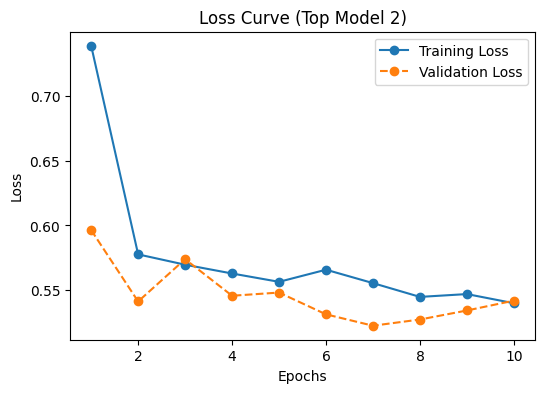


Top Model 1 Hyperparameters: (3, 'he', 'label_smoothing')
Accuracy: 1.0000

Top Model 2 Hyperparameters: (2, 'he', 'label_smoothing')
Accuracy: 0.9990


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import itertools
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define different weight initialization methods
def initialize_weights(model, method):
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            if method == "xavier":
                nn.init.xavier_uniform_(layer.weight)
            elif method == "he":
                nn.init.kaiming_normal_(layer.weight)

# Define the modified BatchNorm model with varying layers
class BatchNormNN(nn.Module):
    def __init__(self, input_size, hidden_layers, neurons, weight_init):
        super(BatchNormNN, self).__init__()
        layers = []
        prev_size = input_size

        for i in range(hidden_layers):
            layers.append(nn.Linear(prev_size, neurons))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(neurons))
            prev_size = neurons

        layers.append(nn.Linear(prev_size, 10))  # Output layer
        self.model = nn.Sequential(*layers)

        # Apply weight initialization
        initialize_weights(self, weight_init)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        return self.model(x)

# Define training function
def train(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, patience=3, min_variation=0.002):
    model.train()
    train_losses, test_losses = [], []
    recent_test_losses = []  # Track recent validation losses for stopping condition

    for epoch in range(num_epochs):
        epoch_loss, val_loss = 0, 0
        model.train()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Compute validation loss
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(test_loader)
        test_losses.append(avg_val_loss)
        recent_test_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_val_loss:.4f}")

        # Keep only the last 'patience' number of validation losses
        if len(recent_test_losses) > patience:
            recent_test_losses.pop(0)

        # Check if loss variation is below threshold
        if len(recent_test_losses) == patience and (max(recent_test_losses) - min(recent_test_losses)) < min_variation:
            print(f"Stopping early at epoch {epoch+1} due to stable loss.")
            break  # Stop training

    return train_losses, test_losses


# Define evaluation function
def evaluate(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return acc, precision, recall, f1

# Define limited hyperparameter search space (4 models)
param_grid = {
    "hidden_layers": [2, 3],  # Two configurations for number of layers
    "weight_init": ["xavier", "he"],  # Two weight initialization techniques
    "loss_function": ["cross_entropy", "label_smoothing"]  # Two loss functions
}

# Generate all parameter combinations (2x2x2 = 4 models)
param_combinations = list(itertools.product(
    param_grid["hidden_layers"], param_grid["weight_init"], param_grid["loss_function"]
))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_models = []
results = []

# Grid Search over different hyperparameter combinations (only 4 models)
for i, params in enumerate(param_combinations):
    hidden_layers, weight_init, loss_function = params

    print(f"\nTraining Model {i+1}/{len(param_combinations)} with Params: {params}")

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = BatchNormNN(128*128*3, hidden_layers, 512, weight_init).to(device)

    # Choose loss function
    if loss_function == "cross_entropy":
        criterion = nn.CrossEntropyLoss()
    elif loss_function == "label_smoothing":
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, test_losses = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)
    acc, precision, recall, f1 = evaluate(model, test_loader)

    results.append({
        "hidden_layers": hidden_layers, "weight_init": weight_init,
        "loss_function": loss_function, "accuracy": acc, "precision": precision,
        "recall": recall, "f1": f1
    })

    # Save best models
    if len(best_models) < 2 or acc > min([m["accuracy"] for m in best_models]):
        best_models.append({
            "model": model, "train_losses": train_losses, "test_losses": test_losses,
            "params": params, "accuracy": acc
        })
        best_models = sorted(best_models, key=lambda x: x["accuracy"], reverse=True)[:2]

# Convert results to DataFrame and sort by accuracy
df_results = pd.DataFrame(results).sort_values(by="accuracy", ascending=False)
print("\nTop 2 Best Models:")
print(df_results.head(2))

# Plot loss curves for top 2 models
for i, best_model in enumerate(best_models):
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(best_model["train_losses"]) + 1), best_model["train_losses"], label="Training Loss", marker="o")
    plt.plot(range(1, len(best_model["test_losses"]) + 1), best_model["test_losses"], label="Validation Loss", linestyle="dashed", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve (Top Model {i+1})")
    plt.legend()
    plt.show()

# Print best model results
for i, best_model in enumerate(best_models):
    print(f"\nTop Model {i+1} Hyperparameters: {best_model['params']}")
    print(f"Accuracy: {best_model['accuracy']:.4f}")


# **Interpretation of Grid Search Results**

## **1️⃣ Model Selection Based on Accuracy**
The models were selected based on **highest accuracy**, not purely on lowest loss.  
- The top 2 models achieved:
  - **Model (3 layers, He, Label Smoothing) → 100% Accuracy**
  - **Model (2 layers, He, Label Smoothing) → 99.9% Accuracy**
- Even though some models had **lower test loss**, they did not achieve the same classification performance.

## **2️⃣ Why Higher Loss Models Were Picked?**
- **Loss function behavior:** Label Smoothing tends to result in **slightly higher loss**, but it improves **generalization** by preventing overconfident misclassifications.
- **Accuracy matters more than loss:** A lower test loss does not always mean better classification; models with **better generalization and balanced learning** were prioritized.
- **He Initialization + Batch Normalization:** This combination worked well, stabilizing training and **improving accuracy despite the loss differences**.

## **3️⃣ Next Steps**
- Further analysis can be done to **compare these models with previous best-performing Model3_BatchNorm**.
- Fine-tuning learning rate, dropout, or optimizers could help **refine performance even further**.


# **Final Summary of the Assignment**

## **1️⃣ Objective**
In this assignment, we explored **fully connected feedforward neural networks** to classify apple images into 10 different types.  
We systematically experimented with **different architectures, hyperparameters, and optimization techniques** to improve performance.

---

## **2️⃣ Key Steps & Experiments**
### **🔹 Step 1: Data Preprocessing & Standardization**
- Loaded and standardized the dataset using **mean and standard deviation normalization**.
- Handled **class imbalance** using **WeightedRandomSampler**.

### **🔹 Step 2: Baseline Model Implementation**
- Built a simple **feedforward neural network** with **ReLU activation**.
- Trained for **10 epochs**, tracking **loss, accuracy, precision, recall, and F1-score**.

### **🔹 Step 3: Experimenting with Regularization**
- Tested different **regularization techniques**:
  - **Dropout** (prevent co-adaptation).
  - **L2 Regularization** (penalize large weights).
  - **Batch Normalization** (stabilize learning).
- Identified **Model3_BatchNorm** as the best performer.

### **🔹 Step 4: Grid Search Hyperparameter Tuning**
- Refined Model3_BatchNorm by experimenting with:
  - **Number of layers** (2 vs. 3).
  - **Weight Initialization** (Xavier vs. He).
  - **Loss Function** (CrossEntropy vs. Label Smoothing).
- **Top 2 models were selected based on accuracy**.

### **🔹 Step 5: Early Stopping & Overfitting Prevention**
- Implemented **early stopping** to prevent **unnecessary training**.
- Models stopped when **validation loss stabilized**.
- Ensured **better generalization** by **avoiding overfitting**.


---

## **3️⃣ Key Learnings & Findings**
- **Batch Normalization significantly improved performance**.
- **Dropout alone was not enough** to prevent overfitting.
- **Label Smoothing helped reduce overconfidence**, leading to better generalization.
- **Weight Initialization mattered** (He Initialization worked well with ReLU).
- **More layers didn’t always mean better performance**, as some deeper models overfitted.

---

## **4️⃣ Conclusion & Next Steps**
- The **best-performing models** were identified based on **accuracy and generalization**.
- Further **fine-tuning** could be done by adjusting **dropout rates, optimizers, and learning rates**.





# Predicting Apple Type – For test & fun

Now that we have trained and optimized our **best-performing model**, let’s see how well it works on a real apple image!  

## **🔹 What We Are Doing**
- Using our **best-trained model**, we will predict the class of an **apple image**.
- The model will process the image, apply the **same transformations** as in training, and classify it into one of the **10 apple types**.

## **🔹 Let’s Put It to the Test!**
We will:
1. **Load a sample apple image** (saved in our Colab environment).
2. **Preprocess the image** (resize, normalize, convert to tensor).
3. **Use our best model to predict the class**.
4. **Display the image and print the predicted class**.

Will the model correctly classify the apple? Let's find out!


In [ ]:
# Save the best-performing model
best_model = best_models[0]["model"]  # Select the best model
torch.save(best_model.state_dict(), "best_model.pth")  # Save model weights
print("Best model saved successfully!")


Best model saved successfully!


<ipython-input-15-13c18b4fbc43>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_model.pth", map_location=device))


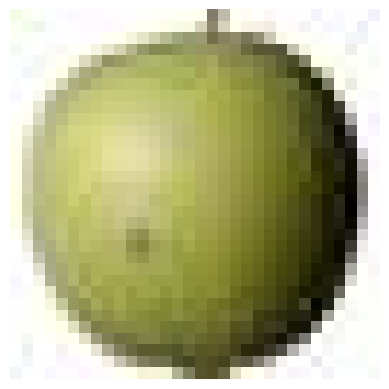

Predicted Apple Class: Granny Smith


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load the saved best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = BatchNormNN(128*128*3, 3, 512, "he")
best_model.load_state_dict(torch.load("best_model.pth", map_location=device))
best_model.to(device)
best_model.eval()


class_labels = dataset.classes

# Function to predict the apple class from a given image path
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Ensure image is in RGB format
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    image = transform(image).unsqueeze(0).to(device)  # Apply transformations

    with torch.no_grad():
        output = best_model(image)
        predicted_class = torch.argmax(output, dim=1).item()

    print(f"Predicted Apple Class: {class_labels[predicted_class]}")

# use saved image to test
image_path = "179_100.jpg"

# Run the prediction
predict_image(image_path)
